In [ ]:
!pip install datasets
!pip install nltk
!pip install gensim

     |████████████████████████████████| 194kB 5.4MB/s 
     |████████████████████████████████| 245kB 15.5MB/s 
     |████████████████████████████████| 112kB 15.8MB/s 
ERROR: Operation cancelled by user


In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger') 

import numpy as np
import pandas as pd
from datasets import list_datasets, load_dataset, list_metrics, load_metric
import nltk
import gensim
from gensim.models import Word2Vec
from nltk.tokenize import sent_tokenize, word_tokenize 
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import re
import string

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
dataset = load_dataset('climate_fever')
stop_words = set(stopwords.words('english'))  


Using custom data configuration default


Dataset climate_fever downloaded and prepared to /root/.cache/huggingface/datasets/climate_fever/default/1.0.1/3b846b20d7a37bc0019b0f0dcbde5bf2d0f94f6874f7e4c398c579f332c4262c. Subsequent calls will reuse this data.


In [ ]:
#print(list_metrics())

In [ ]:
x_data = dataset['test']['claim']
y_data = dataset['test']['claim_label']
#The label correspond to 0: "refutes", 1: "supports" and 2: "not enough info"

x_data[0]

'Global warming is driving polar bears toward extinction'

Need to preprocess the data to remove commas and appostaphies

In [ ]:

corpusW = []
corpusS = []
for col in x_data:
  filtered_sentence = []
  col = re.sub("[^a-zA-Z]", " ",col)
  #remove extra characters
  col = re.sub(r"[[0-9]*\]", " ", col)
  #remove the extra spaces between words
  col = re.sub(r"\s+", " ", col)
  word_tokens = word_tokenize(col)
  for w in word_tokens:  
    wl = w.lower()
    if wl not in stop_words:  
        filtered_sentence.append(wl)
        corpusW.append(wl)
  #print(filtered_sentence)  
    #word_list = sentence[1].split(" ")
  corpusS.append(filtered_sentence)

X_train, X_test = train_test_split(corpusW, test_size=0.2, random_state=0)
#X_val, X_test = train_test_split(X_test, test_size=0.5, random_state=0)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Possible nested set at position 1
  


In [ ]:
model2 = Word2Vec(corpusS, min_count=1, window=7, size=50, iter=100, workers = 20) 
#model2.train(corpusW, total_examples=1, epochs=1)
#model2 = Word2Vec(corpusS,size=50,min_count=1)
print(model2)

Word2Vec(vocab=4074, size=50, alpha=0.025)


Increasing the number of epochs usually benefits the quality of the word representations. In experiments I have performed where the goal was to use the word embeddings as features for text classification setting the epochs to 15 instead of 5, increased the performance.


In [ ]:
words=list(model2.wv.vocab)
len(words)

4074

In [ ]:
#import gensim.downloader as api
#modelGlove = api.load("glove-wiki-gigaword-50")
#corpus8 = api.load('text8')
#model3 = Word2Vec(corpus8, min_count=1, window=7, size=50, workers = 20) 



[==================================================] 100.0% 66.0/66.0MB downloaded
[==================================================] 100.0% 31.6/31.6MB downloaded


In [ ]:
X_pca = model2.wv[X_train]
len(X_pca)

14652

50


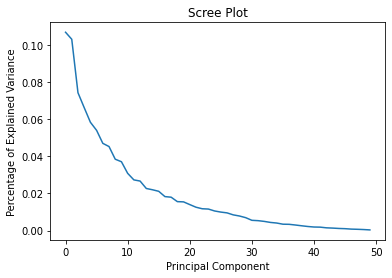

In [ ]:
pca = PCA(n_components=50)
pca_data = pca.fit_transform(X_pca)

per_var = np.array(pca.explained_variance_ratio_)
#labels = ['PC'  + str(x) for x in range(1, len(per_var)+1)]
print(len(per_var))
plt.plot(per_var)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
plt.show()

Based on the above scree plot, the principal component  is the first component as it explains more than 99.9% of the variance.

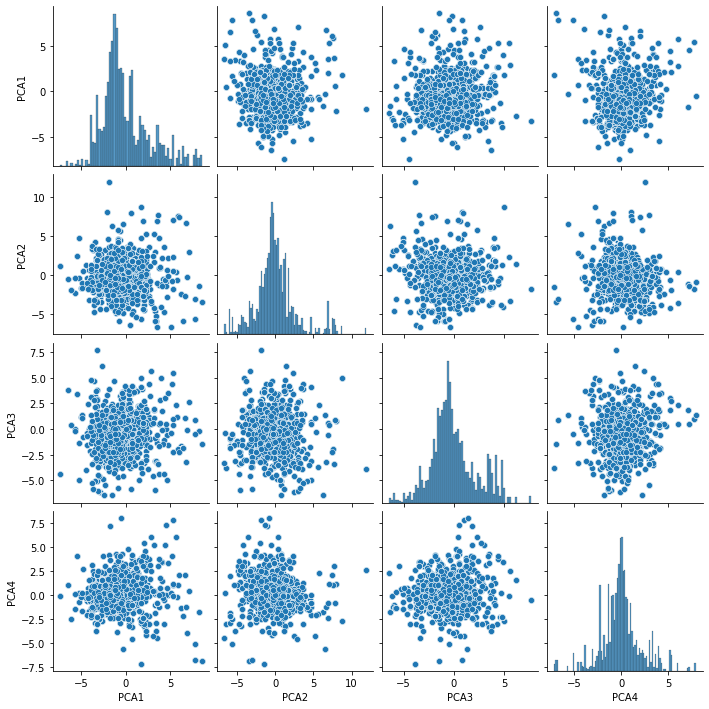

In [ ]:
import seaborn as sns

#Train Data
dfPCA = pd.DataFrame(pca_data[:, 0:4],columns=['PCA1', 'PCA2', 'PCA3', 'PCA4'])
sns.pairplot(dfPCA)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


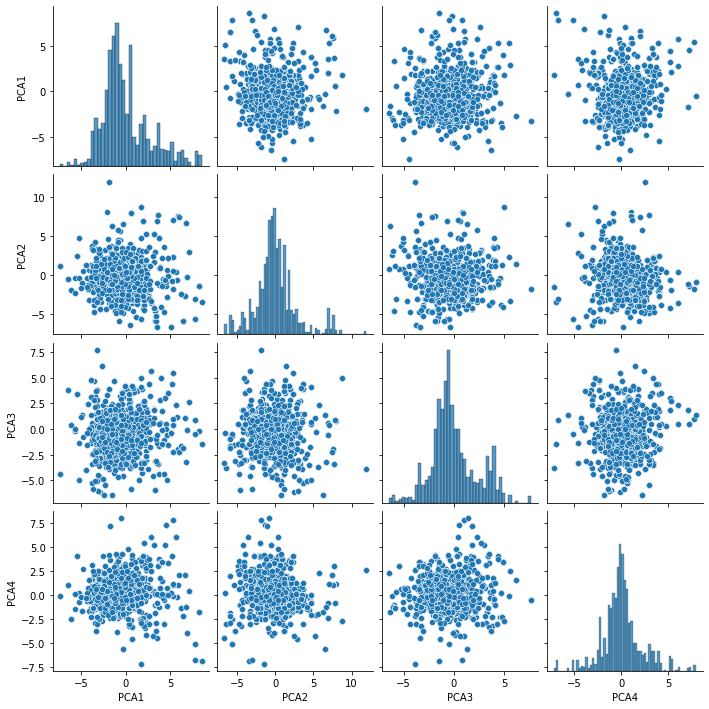

In [ ]:
#Test Data
pca_dataT = pca.transform(model2[X_test])
dfTest = pd.DataFrame(pca_dataT[:, 0:4],columns=['PCA1', 'PCA2', 'PCA3', 'PCA4'])
sns.pairplot(dfTest)

In [ ]:
# Print results 
for wo in range(0,len(X_test)): 
  print(X_test[wo])
  if ((wo+1)<len(X_test)):
    print(X_test[wo+1])
    print("Cosine similarity between - CBOW : ", model1.similarity(X_test[wo], X_test[wo+1])) 

around
old


NameError: ignored

In [ ]:
from sklearn.neighbors import kneighbors_graph
# LLE should preserve distances when all neighbors are used
n_neighbors = pca_dataT.shape[0]
Xt = model2[X_test]

# grid of equidistant points in 2D, n_components = n_dim
#X = np.array(list(product(range(N_per_side), repeat=2)))

# distances from each point to all others
G = kneighbors_graph(Xt, n_neighbors, metric='cosine', mode='distance', include_self=True)

G_tsne = kneighbors_graph(pca_dataT, n_neighbors, metric='cosine', mode='distance', include_self=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


In [ ]:
G.data = (1 - G.data)  # to similarity
print(G.mean())
dfG = pd.DataFrame(G.toarray())
dfG['Labels'] = X_test
dfG



0.16716819


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,3625,3626,3627,3628,3629,3630,3631,3632,3633,3634,3635,3636,3637,3638,3639,3640,3641,3642,3643,3644,3645,3646,3647,3648,3649,3650,3651,3652,3653,3654,3655,3656,3657,3658,3659,3660,3661,3662,3663,Labels
0,1.000000,0.200812,-0.000607,-0.013031,-0.065950,-0.213462,0.079697,0.367577,0.231562,-0.022776,0.466676,0.218687,0.196382,0.343116,0.215155,0.351227,0.154850,0.290172,0.314500,-0.194281,0.175807,0.305575,0.092835,0.198787,0.125071,0.119113,-0.060877,0.208766,0.367577,0.027025,0.231562,0.036526,0.305575,0.070339,0.593224,0.092835,-0.090111,0.397389,0.323074,0.318988,...,0.142721,-0.063946,0.473338,-0.065120,0.084231,-0.075253,0.124002,0.079799,0.031540,0.161351,0.249228,0.028037,0.257891,0.162460,0.125264,0.444199,-0.022537,0.288589,0.347431,0.092835,0.193830,0.078521,0.261500,0.230372,0.226333,0.075182,-0.007695,-0.106456,-0.038282,-0.021524,0.037757,0.086689,0.023749,0.444199,0.155229,0.115433,0.278914,0.102659,0.291968,around
1,0.200812,1.000000,0.238447,0.191811,0.213040,-0.032785,0.206785,0.075559,-0.066878,0.288821,0.051818,0.148808,0.039632,-0.010784,0.234288,0.255773,-0.137058,0.144110,0.686487,0.081575,0.631530,0.260133,0.079035,0.089043,0.246347,0.115635,0.040126,0.108328,0.075559,0.301505,-0.066878,-0.042127,0.260133,-0.127034,0.532339,0.079035,-0.062504,0.641666,-0.058899,0.209370,...,0.013388,0.168095,0.271864,-0.037810,0.231778,0.224549,0.025973,0.142337,0.034222,-0.072762,0.002338,0.321945,0.177381,0.233333,-0.074521,0.029972,0.136166,-0.112107,0.274365,0.079035,0.146022,-0.077915,0.268193,0.059242,0.410323,0.116633,-0.019416,0.347976,0.069756,0.282993,0.181984,0.355507,0.076340,0.029972,0.110846,-0.000806,0.088380,0.673538,0.097370,old
2,-0.000607,0.238447,1.000000,0.239856,0.414201,-0.013133,0.130198,0.327149,-0.004465,0.282015,-0.079556,0.403547,-0.083526,-0.060492,0.028730,0.215533,0.130546,-0.008768,0.084629,0.431995,0.151302,0.228234,-0.203466,0.786265,0.395322,0.139593,0.003205,-0.131102,0.327149,-0.006880,-0.004465,0.019507,0.228234,0.147081,0.121172,-0.203466,0.267918,-0.248972,-0.159338,0.274032,...,0.029141,0.286482,0.547583,-0.008733,0.040821,0.101950,0.421779,0.148453,0.307973,0.141866,0.200629,-0.020507,-0.024116,-0.133960,0.478955,0.136199,0.629931,0.246399,0.285548,-0.203466,0.756088,0.025646,0.195834,0.021340,0.374356,-0.082771,0.039973,0.481596,0.027528,0.109195,-0.006556,0.183824,-0.190437,0.136199,0.279429,0.500138,0.546691,-0.125144,0.025621,dung
3,-0.013031,0.191811,0.239856,1.000000,0.312892,0.185389,0.664521,-0.109197,0.323144,0.529935,0.030795,-0.090508,0.340813,0.418188,0.145292,0.282625,0.416136,0.470377,0.261899,0.424458,0.382212,-0.053718,0.201438,0.176918,0.517645,0.598338,0.129621,0.172023,-0.109197,0.538562,0.323144,0.574034,-0.053718,0.252838,0.184545,0.201438,0.184722,0.194807,0.426792,0.285951,...,0.261949,0.583018,0.390434,0.313053,0.461127,0.220115,0.254676,0.085084,0.433835,0.282178,0.003948,0.443257,0.487230,0.168333,0.398443,0.072203,0.361168,0.217645,0.041466,0.201438,0.523061,0.352466,0.448496,0.527316,0.361868,0.161349,0.206926,0.466850,0.476141,0.251326,0.364340,-0.034249,0.282599,0.072203,0.121884,0.399575,0.088815,0.167527,0.455147,either
4,-0.065950,0.213040,0.414201,0.312892,1.000000,0.370428,0.370322,0.230677,-0.241730,0.086931,0.018898,0.190970,-0.050588,0.037606,0.347270,0.436701,-0.087818,0.165147,-0.009123,0.050522,0.260576,-0.110101,-0.055877,0.243676,0.264134,0.091915,0.142655,0.188494,0.230677,0.105406,-0.241730,0.167485,-0.110101,-0.206731,0.151009,-0.055877,0.243883,-0.065107,-0.243978,-0.156620,...,0.424504,0.216791,0.049988,-0.280371,0.236243,-0.028093,0.338411,0.285686,0.003847,0.044669,0.005266,0.278197,0.007119,0.099095,-0.134444,0.086757,0.232126,0.144270,0.253178,-0.055877,0.255367,-0.029703,0.174872,0.109981,-0.100401,0.277587,0.171736,0.362692,-0.073202,0.348306,0.067228,0.215361,-0.281968,0.086757,0.311653,0.382033,0.089385,0.102896,

In [ ]:
G_tsne.data = (1 - G_tsne.data)  # to similarity
print(G_tsne.mean())
dfG_tsne = pd.DataFrame(G_tsne.toarray())
dfG_tsne['Labels'] = X_test
dfG_tsne

# References

https://remykarem.github.io/word2vec-demo/

**Preprocessing Example:**
https://colab.research.google.com/github/gal-a/blog/blob/master/docs/notebooks/nlp/nltk_preprocess.ipynb#scrollTo=-44aMwUcQZxm

**Word2Vec Implementation Example:**
https://www.youtube.com/watch?v=Z1VsHYcNXDI

**Word2Vec:**
https://jalammar.github.io/illustrated-word2vec/

https://medium.com/swlh/word-embedding-word2vec-with-genism-nltk-and-t-sne-visualization-43eae8ab3e2e

Perhaps you mean “how do we determine Word2vec hyperparameters?”. We can’t determine the parameters of a Word2vec model (two arrays made up of vectors for words in corpus -one array contains the vectors for each word and the other is the context vector that is discarded after training ) - it is automatically learnt by the model during training.

Key hyperparameters we can choose are

The model type (continuous bag of words - surrounding words predicting to word they flank. Skipgram - flanked word predicting all its surrounding words) skipgram typically is favored for large corpus
Sampling method ( hierarchical or negative ) again latter typically preferred for large corpus
Iterations - 5 or even as low as 3 for large corpus of 30 million unique words or more
Dimensions - 300 works for corpus of upto 60 million unique words
Subsampling - determines how often frequently occurring words like “the” are trained. Could be anywhere from 1e-3 to 1e-5. Values lower than 1e-5 tends to influence vector quality
Window size - smaller window size gives results that are more syntactic in nature. Larger window ( size > 5 ) gives results that are more semantic - this takes more training time given larger window size.